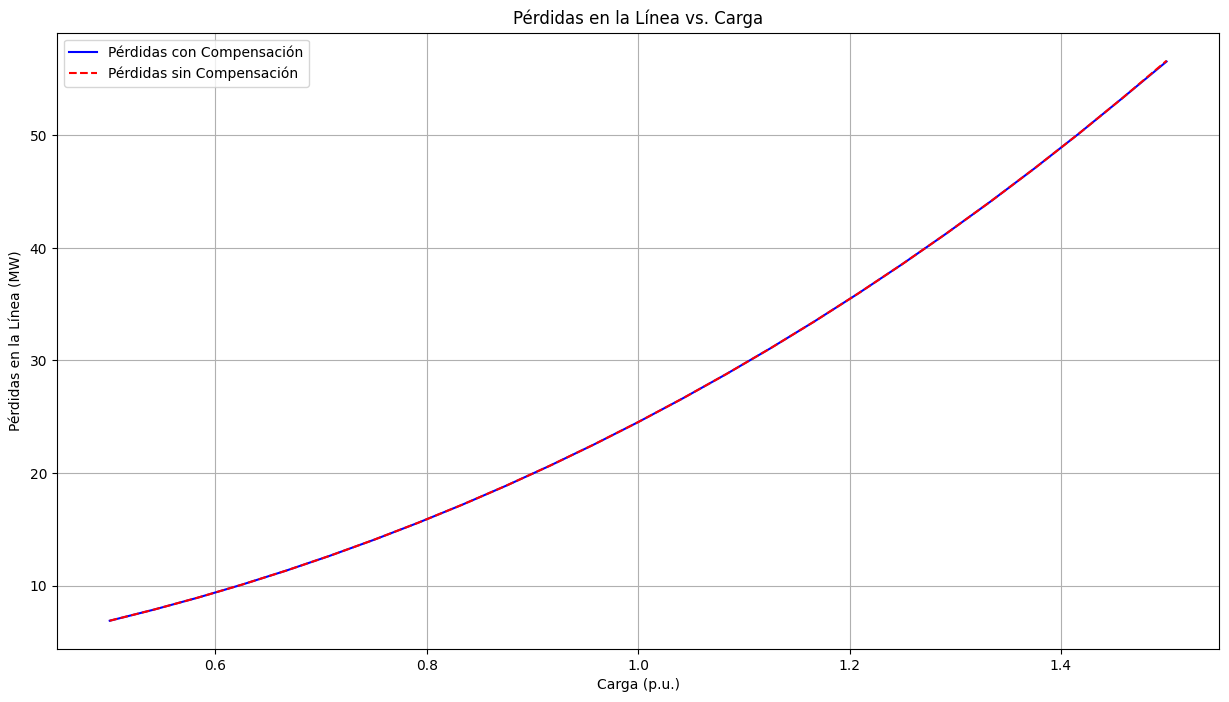

Perdida en la linea sin compensación: 56.64380940329602 [MW]
Perdida en la linea con compensación: 56.573509151084636 [MW]


In [4]:
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np

# Red de referencia
net = pp.create_empty_network()

# Barras
bus1 = pp.create_bus(net, vn_kv=500, name="Bus 1")
bus2 = pp.create_bus(net, vn_kv=500, name="Bus 2")

# Datos de la línea
length_km = 500  
r_ohm_per_km = 0.02  
x_ohm_per_km = 0.115
c_nf_per_km = 19.1  
max_i_ka = 1

# Líneas de transmisión
pp.create_line_from_parameters(net, from_bus=bus1, to_bus=bus2, length_km=length_km,
                               r_ohm_per_km=r_ohm_per_km, x_ohm_per_km=x_ohm_per_km,
                               c_nf_per_km=c_nf_per_km, max_i_ka=max_i_ka, name='Línea 1')
pp.create_line_from_parameters(net, from_bus=bus1, to_bus=bus2, length_km=length_km,
                               r_ohm_per_km=r_ohm_per_km, x_ohm_per_km=x_ohm_per_km,
                               c_nf_per_km=c_nf_per_km, max_i_ka=max_i_ka, name='Línea 2')

# Barra slack
pp.create_ext_grid(net, bus=bus1, vm_pu=1.0)

# Carga nominal
p_nominal = 1080  # MW
q_nominal = 523.068  # MVAr

# Rango de carga ±50%
p_values = np.linspace(0.5 * p_nominal, 1.5 * p_nominal, 25)
voltages = []
compensations = []
perdidas_con_comp = []
perdidas_sin_comp = []

# Simular sin compensación para cada valor de carga
for p in p_values:
    pp.create_load(net, bus=bus2, p_mw=p, q_mvar=q_nominal)
    pp.runpp(net)
    
    # Registrar pérdidas sin compensación
    perdidas_sin_comp.append(net.res_line.pl_mw.sum())
    
    net.load.drop(net.load.index, inplace=True)  # Resetear las cargas para la próxima simulación

# Simular con compensación para cada valor de carga
for p in p_values:
    pp.create_load(net, bus=bus2, p_mw=p, q_mvar=q_nominal)
    pp.runpp(net)
    
    # Compensación shunt necesaria
    vm = net.res_bus.vm_pu[bus2]
    q_shunt = 0
    tolerance = 0.001  # Tolerancia para iteraciones
    max_iteraciones = 20  # Número máximo de iteraciones
    iteracion = 0
    
    while (vm < 0.97 or vm > 1.03) and iteracion < max_iteraciones:
        if vm < 0.97:
            q_shunt += (0.97 - vm) * p_nominal  # Compensar con reactancia inductiva
        elif vm > 1.03:
            q_shunt -= (vm - 1.03) * p_nominal  # Compensar con reactancia capacitiva
        
        # Agregar la compensación shunt
        if q_shunt != 0:
            pp.create_sgen(net, bus=bus2, p_mw=0, q_mvar=q_shunt)
            pp.runpp(net)
            vm = net.res_bus.vm_pu[bus2]
            net.sgen.drop(net.sgen.index, inplace=True)  # Resetear la compensación shunt
        
        iteracion += 1
    
    voltages.append(vm)
    compensations.append(q_shunt)
    perdidas_con_comp.append(net.res_line.pl_mw.sum())
    
    net.load.drop(net.load.index, inplace=True)  # Resetear las cargas para la próxima simulación

# Graficar los resultados
plt.figure(figsize=(15, 8))
plt.plot(p_values / p_nominal, perdidas_con_comp, 'b-', label="Pérdidas con Compensación")
plt.plot(p_values / p_nominal, perdidas_sin_comp, 'r--', label="Pérdidas sin Compensación")
plt.title('Pérdidas en la Línea vs. Carga')
plt.xlabel('Carga (p.u.)')
plt.ylabel('Pérdidas en la Línea (MW)')
plt.legend()
plt.grid()
plt.show()
# Para comprobar valores
#print(perdidas_sin_comp)
#print(perdidas_con_comp)
print("Perdida en la linea sin compensación: 56.64380940329602 [MW]")
print("Perdida en la linea con compensación: 56.573509151084636 [MW]")